In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [54]:
mnist.train.next_batch?


In [3]:
#ed.set_seed(314159)
N = 100   # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.

In [4]:
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w = Normal(loc=tf.zeros([D, K]), scale=tf.ones([D, K]))
b = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y = Categorical(tf.matmul(x,w)+b)

In [5]:
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w = Normal(loc=tf.zeros([D, K]), scale=tf.ones([D, K]))
b = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y = Categorical(tf.matmul(x,w)+b)


In [6]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw = Normal(loc=tf.Variable(tf.random_normal([D, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qb = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))



In [7]:


# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.KLqp({w: qw, b: qb}, data={y:y_ph})



In [43]:
mnist.train.num_examples

55000

In [8]:


# Initialse the infernce variables
inference.initialize(n_iter=5000, n_print=100, scale={y: float(mnist.train.num_examples) / N})



In [9]:


# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()



In [10]:


# Let the training begin. We load the data in minibatches and update the VI infernce using each new batch.
for _ in range(inference.n_iter):
    X_batch, Y_batch = mnist.train.next_batch(N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch,axis=1)
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
    inference.print_progress(info_dict)



5000/5000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 39267.023


In [11]:


# Load the test images.
X_test = mnist.test.images
# TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
Y_test = np.argmax(mnist.test.labels,axis=1)

In [13]:


# Generate samples the posterior and store them.
n_samples = 10
prob_lst = []
samples = []
w_samples = []
b_samples = []
for _ in range(n_samples):
    w_samp = qw.sample()
    b_samp = qb.sample()
    w_samples.append(w_samp)
    b_samples.append(b_samp)
    # Also compue the probabiliy of each class for each (w,b) sample.
    prob = tf.nn.softmax(tf.matmul( X_test,w_samp ) + b_samp)
    prob_lst.append(prob.eval())
    sample = tf.concat([tf.reshape(w_samp,[-1]),b_samp],0)
    samples.append(sample.eval())



Text(0,0.5,'Frequency')

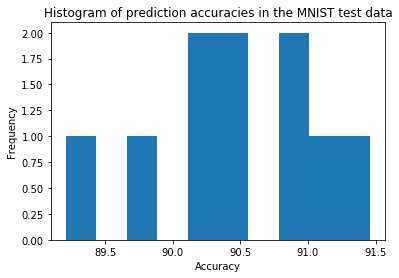

In [14]:


# Compute the accuracy of the model. 
# For each sample we compute the predicted class and compare with the test labels.
# Predicted class is defined as the one which as maximum proability.
# We perform this test for each (w,b) in the posterior giving us a set of accuracies
# Finally we make a histogram of accuracies for the test data.
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = (y_trn_prd == Y_test).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")



In [15]:


# Here we compute the mean of probabilties for each class for all the (w,b) samples.
# We then use the class with maximum of the mean proabilities as the prediction. 
# In other words, we have used (w,b) samples to construct a set of models and
# used their combined outputs to make the predcitions.
Y_pred = np.argmax(np.mean(prob_lst,axis=0),axis=1)
print("accuracy in predicting the test data = ", (Y_pred == Y_test).mean()*100)



accuracy in predicting the test data =  92.49000000000001


/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)


Text(0.5,0.98,'Joint posterior distribution of the first 5 weights')

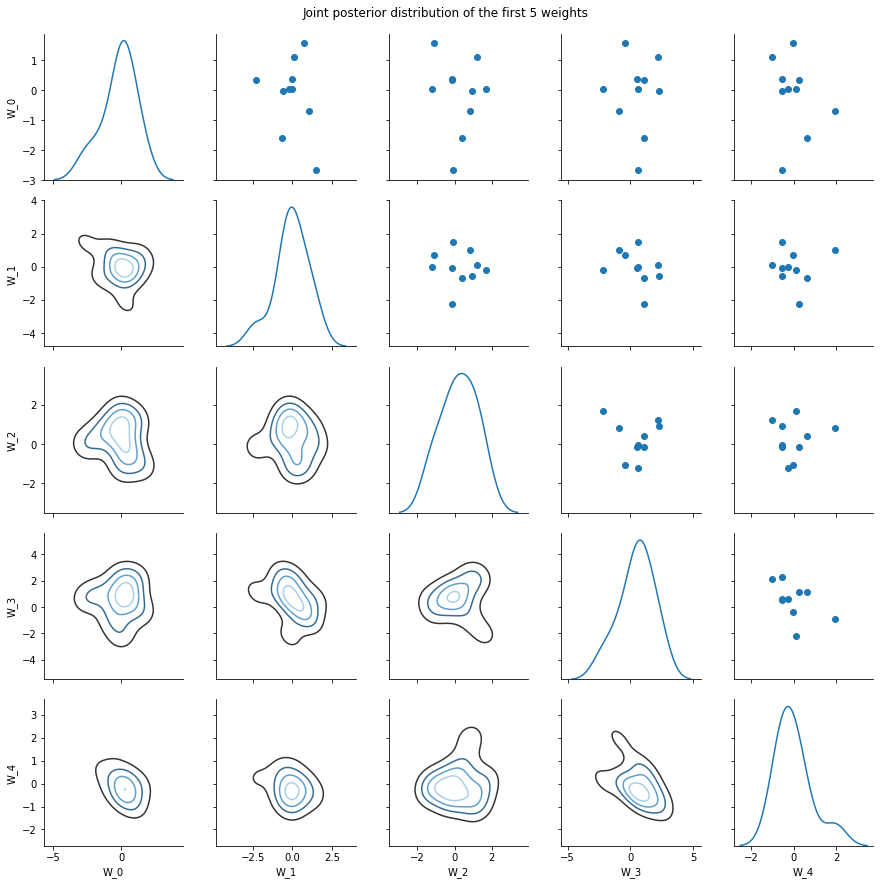

In [16]:
# Create a Pandas DataFrame of posterior samples.
samples_df = pd.DataFrame(data = samples, index=range(n_samples))
# Now create a small subset by taking the first 5 weights, labelled as W_0, ... , W_4.
samples_5 = pd.DataFrame(data = samples_df[list(range(5))].values,columns=["W_0", "W_1", "W_2", "W_3", "W_4"])
# We use Seaborn PairGrid to make a triale plot to show auto and cross correlations.
g = sns.PairGrid(samples_5, diag_sharey=False)
g.map_lower(sns.kdeplot, n_levels = 4,cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot,legend=False)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Joint posterior distribution of the first 5 weights')

truth =  7


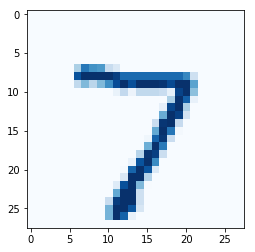

In [17]:
# Load the first image from the test data and its label.
test_image = X_test[0:1]
test_label = Y_test[0]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels,cmap='Blues')


In [18]:
# Now the check what the model perdicts for each (w,b) sample from the posterior. This may take a few seconds...
sing_img_probs = []
for w_samp,b_samp in zip(w_samples,b_samples):
    prob = tf.nn.softmax(tf.matmul( X_test[0:1],w_samp ) + b_samp)
    sing_img_probs.append(prob.eval())

Text(0,0.5,'Frequency')

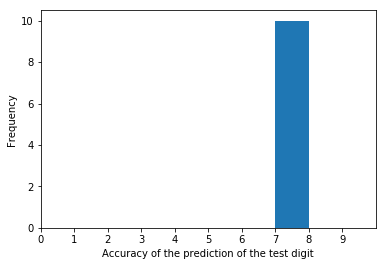

In [19]:
# Create a histogram of these predictions.
plt.hist(np.argmax(sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test digit")
plt.ylabel("Frequency")